<a href="https://colab.research.google.com/github/AhmedAtefGaber/Speaker-Identification/blob/master/spk_id_spectogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pydub

In [0]:
!pip install librosa

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import IPython
import numpy as np
import glob as glob 
from scipy.io import wavfile
import librosa as librosa
import os
import random
from scipy.io import wavfile
from sklearn.utils import shuffle
from pydub import AudioSegment

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
input_length = 16000
n_mels = 320

In [0]:
def preprocess_audio_mel_T(audio, sample_rate=16000, window_size=20,step_size=10, eps=1e-10):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels= n_mels)
    mel_db = (librosa.power_to_db(mel_spec, ref=np.max) + 40)/40

    return mel_db.T

In [0]:
def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=16000)[0] 
    if len(data)>input_length:
        
        
        max_offset = len(data)-input_length
        
        offset = np.random.randint(max_offset)
        
        data = data[offset:(input_length+offset)]
        
        
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)

            offset = np.random.randint(max_offset)
        else:
            offset = 0
        
        
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        
    data = preprocess_audio_mel_T(data)
    return data.reshape(32,320,1)


In [0]:
def load_raw_audio():
    spk_1=[]
    spk_2=[]
    for filename in os.listdir("/content/drive/My Drive/spk_id/train/spk_1"):
        if filename.endswith("wav"):
            spk = "/content/drive/My Drive/spk_id/train/spk_1/"+filename
            spk_1.append(spk)
    for filename in os.listdir("/content/drive/My Drive/spk_id/train/spk_2"):
        if filename.endswith("wav"):
            spk = "/content/drive/My Drive/spk_id/train/spk_2/"+filename
            spk_2.append(spk)
    
    return spk_1,spk_2

In [0]:
spk_1, spk_2 = load_raw_audio()

In [0]:
x_audio=spk_1+spk_2
y=[0]*len(spk_1)+[1]*len(spk_2)
x_audio,y=shuffle(x_audio,y)

In [0]:
x=np.zeros((1099,32,320,1))
for i in range(1099):
  data=load_audio_file(x_audio[i])
  x[i,:,:,:]=data

In [0]:
model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(8, (3, 3), padding='same',input_shape=(32, 320, 1)),
                            tf.keras.layers.Activation('relu'),
                            tf.keras.layers.Conv2D(8, (3, 3)),
                            tf.keras.layers.Activation('relu'),
                            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                            tf.keras.layers.Dropout(0.25),
                            tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
                            tf.keras.layers.Activation('relu'),
                            tf.keras.layers.Conv2D(16, (3, 3)),
                            tf.keras.layers.Activation('relu'),
                            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(57),
                            tf.keras.layers.Activation('relu'),
                            tf.keras.layers.Dense(1),
                            tf.keras.layers.Activation('sigmoid')
                            ])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 320, 8)        80        
_________________________________________________________________
activation_12 (Activation)   (None, 32, 320, 8)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 318, 8)        584       
_________________________________________________________________
activation_13 (Activation)   (None, 30, 318, 8)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 159, 8)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 159, 8)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 159, 16)      

In [0]:
opt =tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history=model.fit(x,y, epochs=10,validation_split=0.1,verbose=1)

Train on 989 samples, validate on 110 samples
Epoch 1/10
989/989 [==============================] - 1s 769us/sample - loss: 0.0199 - acc: 0.9970 - val_loss: 0.0165 - val_acc: 0.9818
Epoch 2/10
989/989 [==============================] - 0s 253us/sample - loss: 0.0482 - acc: 0.9889 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 3/10
989/989 [==============================] - 0s 255us/sample - loss: 8.5715e-04 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 1.0000
Epoch 4/10
989/989 [==============================] - 0s 251us/sample - loss: 7.1733e-04 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 5/10
989/989 [==============================] - 0s 257us/sample - loss: 1.2515e-04 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 6/10
989/989 [==============================] - 0s 256us/sample - loss: 1.4921e-04 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 7/10
989/989 [==============================] - 0s 262us/sample - loss: 5.8603e-05 - acc: 1.0000 - val_loss: 0.0037 

<Figure size 432x288 with 0 Axes>

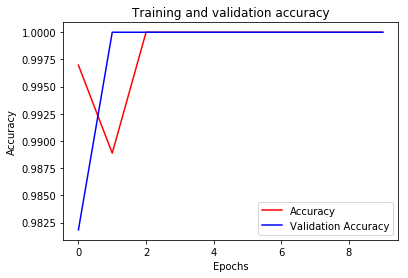

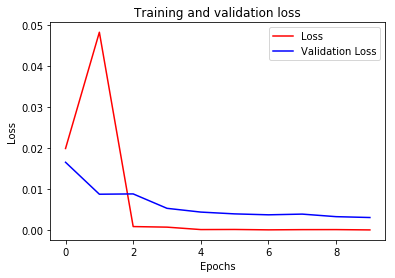

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [0]:
def load_raw_audio_test():
    spk_1=[]
    spk_2=[]
    for filename in os.listdir("/content/drive/My Drive/spk_id/test/spk_1"):
        if filename.endswith("wav"):
            spk = "/content/drive/My Drive/spk_id/test/spk_1/"+filename
            spk_1.append(spk)
    for filename in os.listdir("/content/drive/My Drive/spk_id/test/spk_2"):
        if filename.endswith("wav"):
            spk = "/content/drive/My Drive/spk_id/test/spk_2/"+filename
            spk_2.append(spk)
    
    return spk_1,spk_2

In [0]:
spk_1_test, spk_2_test = load_raw_audio_test()

In [0]:
x_audio_test=spk_1_test+spk_2_test
y_test=[0]*len(spk_1_test)+[1]*len(spk_2_test)

In [0]:
x_test=np.zeros((20,32,320,1))
for i in range(20):
  data=load_audio_file(x_audio_test[i])
  x_test[i,:,:,:]=data

In [0]:
y_test=np.array(y_test)

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)

In [0]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 100.00%
